In [2]:
pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 2.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import multiprocessing
import seaborn as sns
import math
import matplotlib.pyplot as plt
from joblib import dump, load
import xgboost as xgb

from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import permutation_importance
from datetime import date
import glob, os
import time
import random
random.seed(42)
np.random.seed(42)
from collections import defaultdict

import xlsxwriter
from ipynb.fs.full.Data_Preparation import getProcessedData
from ipynb.fs.full.Data_Preparation import getFilenames
from ipynb.fs.full.Data_Preparation import getProcessedData_strategy
from ipynb.fs.full.Data_Preparation import getProcessedData_test

In [11]:
path = os.getcwd()

In [13]:
# Create a dictionary that defines the top 20 features for each currency ticker. These features are selected by SFFS
feat_20={
    'USDEUR': [0, 6, 11, 12, 16, 22, 23, 24, 25, 28, 30, 31, 33, 38, 44, 45, 48, 49, 54, 59],
    'USDJPY': [0, 13, 14, 15, 16, 18, 19, 20, 21, 22, 26, 28, 31, 33, 35, 38, 41, 47, 51, 53],
    'USDGBP': [1, 2, 5, 13, 16, 18, 23, 24, 25, 31, 35, 36, 38, 41, 42, 46, 48, 51, 52, 54],
    'USDCHF': [2, 5, 7, 8, 10, 11, 17, 25, 27, 35, 41, 43, 47, 48, 51, 52, 53, 54, 55, 57],
    'USDNZD': [5, 6, 8, 10, 13, 14, 17, 20, 21, 23, 24, 25, 33, 37, 40, 43, 51, 52, 53, 57],
    'USDCAD': [5, 8, 10, 11, 17, 18, 20, 23, 24, 25, 31, 33, 35, 40, 42, 52, 54, 55, 56, 57],
    'USDSEK': [7, 8, 10, 11, 17, 18, 21, 23, 24, 25, 26, 27, 31, 33, 35, 40, 42, 43, 53, 55],
    'USDDKK': [1, 3, 7, 13, 14, 17, 22, 23, 26, 27, 28, 29, 30, 31, 35, 44, 48, 51, 52, 53],
    'USDNOK': [0, 2, 4, 5, 7, 15, 17, 18, 20, 22, 23, 26, 27, 33, 34, 37, 47, 49, 51, 57],
    'EURJPY': [0, 1, 4, 9, 13, 20, 21, 23, 24, 25, 26, 29, 31, 41, 44, 47, 51, 53, 54, 56],
    'EURGBP': [4, 5, 7, 8, 13, 17, 18, 20, 21, 23, 24, 25, 27, 41, 42, 47, 51, 52, 54, 55],
    'EURCHF': [4, 11, 12, 14, 17, 18, 19, 26, 29, 32, 33, 34, 39, 40, 45, 47, 49, 50, 51, 52],
    'EURNZD': [8, 9, 10, 11, 16, 18, 21, 23, 26, 28, 31, 35, 36, 38, 46, 50, 51, 52, 53, 55],
    'EURCAD': [5, 8, 10, 11, 18, 20, 21, 23, 24, 25, 26, 28, 32, 33, 41, 42, 43, 46, 48, 58],
    'EURSEK': [2, 4, 8, 10, 11, 13, 15, 20, 22, 23, 33, 39, 40, 41, 44, 48, 51, 54, 55, 59],
    'EURDKK': [1, 6, 8, 10, 17, 21, 26, 30, 31, 35, 37, 43, 44, 45, 47, 48, 50, 51, 55, 58],
    'EURNOK': [2, 8, 10, 11, 13, 17, 18, 21, 23, 24, 25, 40, 41, 42, 43, 47, 53, 56, 57, 58]
}

In [14]:
# Define the list of currency tickers used in the analysis
fx_tic = ['USDEUR',
            'USDJPY',
            'USDGBP',
            'USDCHF',
            'USDNZD',
            'USDCAD',
            'USDSEK',
            'USDDKK',
            'USDNOK',
            'EURJPY',
            'EURGBP',
            'EURCHF',
            'EURNZD',
            'EURCAD',
            'EURSEK',
            'EURDKK',
            'EURNOK']

In [15]:
# Create a dictionary that maps each currency ticker to an index
fx_dic = {}
for i, tic in enumerate(fx_tic):
  fx_dic[tic] = i

fx_dic

{'USDEUR': 0,
 'USDJPY': 1,
 'USDGBP': 2,
 'USDCHF': 3,
 'USDNZD': 4,
 'USDCAD': 5,
 'USDSEK': 6,
 'USDDKK': 7,
 'USDNOK': 8,
 'EURJPY': 9,
 'EURGBP': 10,
 'EURCHF': 11,
 'EURNZD': 12,
 'EURCAD': 13,
 'EURSEK': 14,
 'EURDKK': 15,
 'EURNOK': 16}

In [16]:
df_final = pd.read_csv(path + '/Monthly_accumulative_profit.csv',index_col=0)

In [17]:
df_final

,USDEUR,USDJPY,USDGBP,USDCHF,USDNZD,USDCAD,USDSEK,USDDKK,USDNOK,EURJPY,EURGBP,EURCHF,EURNZD,EURCAD,EURSEK,EURDKK,EURNOK
2019-01,0.035570,0.013274,0.013620,-0.068060,0.038982,0.029783,-0.106543,0.035873,0.112301,0.342885,-0.281736,0.066826,0.025509,0.161845,0.133671,0.039633,0.020492
2019-02,-0.036295,-0.033018,-0.032392,0.066056,-0.179274,0.096732,-0.133763,-0.019042,0.084284,-0.015735,0.043098,0.030622,-0.272576,0.016478,-0.111371,-0.000264,-0.062323
2019-03,-0.004981,-0.021173,0.144223,-0.053441,-0.096671,0.089265,0.237613,0.065606,-0.006364,0.051928,-0.046745,0.034517,-0.205331,-0.149826,0.153142,0.010317,-0.002557
2019-04,0.068377,-0.001864,-0.063749,0.039326,-0.081552,-0.155505,0.096499,0.022608,-0.140734,0.005055,0.027576,-0.147261,0.286236,0.061458,0.112719,0.028821,-0.008257
2019-05,-0.051442,0.033686,0.042988,0.079784,0.123615,-0.073103,0.092368,-0.088954,0.002138,-0.065583,0.126390,0.044404,-0.167038,0.011675,-0.155086,0.018898,-0.163219
2019-06,0.045154,-0.085696,0.003519,0.158403,0.023639,0.127572,0.059950,0.007358,-0.030821,-0.047647,-0.060488,0.002624,0.016130,0.112945,-0.075775,0.009373,-0.028418
2019-07,-0.000782,-0.011439,-0.039821,0.068051,-0.173142,0.014625,0.150628,0.057652,0.000296,0.105662,-0.011499,-0.043351,-0.058303,-0.035722,-0.202514,0.000149,0.083297
2019-08,-0.105551,0.044002,0.011874,0.137730,-0.028221,-0.002271,0.005848,0.005588,0.095464,-0.067674,-0.058119,-0.072649,0.128344,0.078431,0.086608,0.009514,0.098191
2019-09,-0.072648,0.033842,0.030406,0.075005,0.108658,-0.128880,0.185324,-0.021675,-0.074384,0.070985,0.045893,-0.017133,-0.045684,-0.044455,-0.163447,0.035814,-0.091987
2019-10,-0.030783,-0.027881,-0.140985,0.022330,0.093134,-0.011565,0.223466,-0.009141,-0.003331,0.061844,0.132549,0.004992,0.040984,0.131700,-0.078206,0.013250,-0.040490


In [18]:
# Finds the maximum subarray using Kadane's algorithm
def max_subarray(data):
    # Initialize max_sum to negative infinity
    max_sum = -np.inf
    # Current sum
    temp_sum = 0
    start = 0
    end = 0
    temp_start = 0

    # Iterate over the array
    for i in range(len(data)):
        if temp_sum <= 0:
            temp_sum = data[i]
            temp_start = i
        else:
            temp_sum += data[i]
        # Update maximum sum if current sum becomes larger
        if temp_sum > max_sum:
            max_sum = temp_sum
            start = temp_start
            end = i

    return max_sum, start, end

In [19]:
# Finds the minimum subarray by transforming the problem to the max_subarray problem
def min_subarray(data):
    # Initialize min_sum to positive infinity
    min_sum = np.inf
    # Current sum
    temp_sum = 0
    start = 0
    end = 0
    temp_start = 0

    # Iterate over the array
    for i in range(len(data)):
        if temp_sum >= 0:
            temp_sum = data[i]
            temp_start = i
        else:
            temp_sum += data[i]
        # Update minimum sum if current sum becomes smaller
        if temp_sum < min_sum:
            min_sum = temp_sum
            start = temp_start
            end = i

    return min_sum, start, end

In [20]:
# Compute max and min subarray for each column in df_final
results = {}

for col in df_final.columns:
    data = df_final[col].values
    max_profit, max_start, max_end = max_subarray(data)
    min_profit, min_start, min_end = min_subarray(data)

    results[col] = {
        'max_profit': max_profit,
        'max_months': (df_final.index[max_start], df_final.index[max_end]),
        'min_profit': min_profit,
        'min_months': (df_final.index[min_start], df_final.index[min_end]),
    }


In [21]:
# Display the results for each market
for market, res in results.items():
    print(f"{market}:")
    print(f"  Max profit: {res['max_profit']}, from {res['max_months'][0]} to {res['max_months'][1]}")
    print(f"  Min profit: {res['min_profit']}, from {res['min_months'][0]} to {res['min_months'][1]}")

USDEUR:
  Max profit: 0.0683772301190099, from 2019-04 to 2019-04
  Min profit: -0.3638445419201772, from 2019-05 to 2019-12
USDJPY:
  Max profit: 0.0778435158196865, from 2019-08 to 2019-09
  Min profit: -0.12403104541405231, from 2019-02 to 2019-11
USDGBP:
  Max profit: 0.1442230913511033, from 2019-03 to 2019-03
  Min profit: -0.3861634423361959, from 2019-04 to 2019-11
USDCHF:
  Max profit: 0.6094988509362403, from 2019-02 to 2019-12
  Min profit: -0.0680595336737144, from 2019-01 to 2019-01
USDNZD:
  Max profit: 0.2017918403591445, from 2019-09 to 2019-10
  Min profit: -0.8163406920832839, from 2019-02 to 2019-11
USDCAD:
  Max profit: 0.2157805744119167, from 2019-01 to 2019-03
  Min profit: -0.3392265331777388, from 2019-04 to 2019-12
USDSEK:
  Max profit: 1.0516963412323994, from 2019-03 to 2019-10
  Min profit: -0.2403060993901418, from 2019-01 to 2019-02
USDDKK:
  Max profit: 0.1050438702529742, from 2019-01 to 2019-04
  Min profit: -0.0889541386112746, from 2019-05 to 2019-05

In [26]:
results

{'USDEUR': {'max_profit': 0.0683772301190099,
  'max_months': ('2019-04', '2019-04'),
  'min_profit': -0.3638445419201772,
  'min_months': ('2019-05', '2019-12')},
 'USDJPY': {'max_profit': 0.0778435158196865,
  'max_months': ('2019-08', '2019-09'),
  'min_profit': -0.12403104541405231,
  'min_months': ('2019-02', '2019-11')},
 'USDGBP': {'max_profit': 0.1442230913511033,
  'max_months': ('2019-03', '2019-03'),
  'min_profit': -0.3861634423361959,
  'min_months': ('2019-04', '2019-11')},
 'USDCHF': {'max_profit': 0.6094988509362403,
  'max_months': ('2019-02', '2019-12'),
  'min_profit': -0.0680595336737144,
  'min_months': ('2019-01', '2019-01')},
 'USDNZD': {'max_profit': 0.2017918403591445,
  'max_months': ('2019-09', '2019-10'),
  'min_profit': -0.8163406920832839,
  'min_months': ('2019-02', '2019-11')},
 'USDCAD': {'max_profit': 0.2157805744119167,
  'max_months': ('2019-01', '2019-03'),
  'min_profit': -0.3392265331777388,
  'min_months': ('2019-04', '2019-12')},
 'USDSEK': {'ma

In [39]:
# Extracts the data corresponding to months with max and min profits
def min_max_Month(fx_tic = fx_tic, fx_dic = fx_dic, feat_20 = feat_20, results = results):
    # Dictionary to store the max datasets
    max_datasets = {}
    # Dictionary to store the min datasets
    min_datasets = {}
    i = 0
    
    # Loop through each ticker and extract data for max and min cumulative months
    for market, res in results.items():
        # Data split
        # 2019 data with 5 days lag
        X_test_strategy, y_test_strategy = getProcessedData_strategy(getFilenames(fx_tic)[fx_dic[market]])
        # For each market, we only use top 20 features selected by SFFS
        X_test_used = X_test_strategy.iloc[:, feat_20[market]]
        # Convert the index to datetime
        X_test_used.index = pd.to_datetime(X_test_used.index)
        y_test_strategy.index = pd.to_datetime(y_test_strategy.index)

        # Convert the max and min cumulative months strings to datetime format
        max_start, max_end = pd.to_datetime(res['max_months'])
        min_start, min_end = pd.to_datetime(res['min_months'])

        # Adjust end month to cover the entire month
        max_end = max_end + pd.offsets.MonthEnd(1)
        min_end = min_end + pd.offsets.MonthEnd(1)

        # Create masks to filter the data for the max and min cumulative months
        max_mask = (X_test_used.index >= max_start) & (X_test_used.index <= max_end)
        min_mask = (X_test_used.index >= min_start) & (X_test_used.index <= min_end)

        # Filter the data based on the created masks
        max_X = X_test_used.loc[max_mask, ]
        max_Y = y_test_strategy[max_mask]

        min_X = X_test_used.loc[min_mask, ]
        min_Y = y_test_strategy[min_mask]

        # Store the filtered data in the respective dictionaries
        max_datasets[market] = (max_X, max_Y)
        min_datasets[market] = (min_X, min_Y)

    # Return both max and min datasets
    return max_datasets, min_datasets

In [40]:
# Fetch the max and min datasets using the above function
max_datasets, min_datasets = min_max_Month(fx_tic, fx_dic, feat_20, results)

In [49]:
# Computes the permutation feature importance for given tickers on both the max and min datasets
def XGB_PFI_Cum_Month(ticker_names, feat_20 = feat_20, max_datasets = max_datasets, min_datasets = min_datasets):
    # Dictionary to store results for each ticker
    res_all_pairs = {}

    # Determine the number of CPU cores for parallel computation
    n_cores = multiprocessing.cpu_count()

    # Loop through each ticker
    for ticker in ticker_names:
        # Initialize the dictionary to store results for current ticker
        res_all_pairs[ticker] = {'Max': {}, 'Min': {}}

        # Extract the test datasets for the current ticker
        X_test_best = max_datasets[ticker][0]
        X_test_worst = min_datasets[ticker][0]

        y_test_best = max_datasets[ticker][1]
        y_test_worst = min_datasets[ticker][1]

        # Load the previously trained model with best hyperparameters for the current ticker
        xgb_model = load(path + '/Strategy_XGB_weight/' + ticker + 'xgb_strategy.h5')


        # Calculate permutation importance for the max dataset
        result_best = permutation_importance(xgb_model, X_test_best, y_test_best, n_jobs = n_cores, n_repeats=5, random_state=42)
        # Calculate permutation importance for the min dataset
        result_worst = permutation_importance(xgb_model, X_test_worst, y_test_worst, n_jobs = n_cores, n_repeats=5, random_state=42)

        # Store the average PFI score for each feature in a dictionary
        result_global_pfi_best = {feature: pfi_score for feature, pfi_score in zip(X_test_best.columns, result_best.importances_mean)}
        result_global_pfi_worst = {feature: pfi_score for feature, pfi_score in zip(X_test_worst.columns, result_worst.importances_mean)}

        # Sort and store the results in the final dictionary
        res_all_pairs[ticker]['Max'] = sorted(result_global_pfi_best.items(), key=lambda x: x[1], reverse=True)
        res_all_pairs[ticker]['Min'] = sorted(result_global_pfi_worst.items(), key=lambda x: x[1], reverse=True)

    return res_all_pairs


In [50]:
import warnings
warnings.filterwarnings("ignore")

In [51]:
# Calculate PFI for given tickers
PFI_Final = XGB_PFI_Cum_Month(fx_tic)

In [52]:
PFI_Final

{'USDEUR': {'Max': [('NATR', 0.12727272727272726),
   ('ROC', 0.05454545454545455),
   ('Open', 0.0),
   ('Typical_Price', 0.0),
   ('EMA', 0.0),
   ('BB_MAVG', 0.0),
   ('TRIMA', 0.0),
   ('AROONOSC', 0.0),
   ('DEMA', 0.0),
   ('MIDPRICE', 0.0),
   ('PSL', 0.0),
   ('ACC_MID', 0.0),
   ('KC_LOWER', 0.0),
   ('CHANDELIER_LONG', 0.0),
   ('DO_UP', 0.0),
   ('AROON_UP', -0.009090909090909071),
   ('VORTEX_NEG', -0.009090909090909071),
   ('KC_UPPER', -0.009090909090909084),
   ('AROON_DOWN', -0.02727272727272726),
   ('HMA', -0.07272727272727275)],
  'Min': [('ROC', 0.013793103448275845),
   ('EMA', 0.011494252873563204),
   ('NATR', 0.011494252873563204),
   ('HMA', 0.004597701149425282),
   ('Typical_Price', 0.0),
   ('ACC_MID', 0.0),
   ('DO_UP', 0.0),
   ('TRIMA', -2.2204460492503132e-17),
   ('Open', -0.0011494252873563316),
   ('CHANDELIER_LONG', -0.0011494252873563316),
   ('BB_MAVG', -0.011494252873563237),
   ('AROON_DOWN', -0.011494252873563237),
   ('PSL', -0.0114942528735632

In [53]:
# Save the results to a h5 file
dump(PFI_Final, path + '/Strategy_PFI_Cum_Month.h5')

['/content/gdrive/MyDrive/Capstone-main/Strategy_PFI_Cum_Month.h5']

In [54]:
# Plots the PFI scores for each ticker and dataset
def plot_pfi(res_all_pairs):
    for ticker, pfi_data in res_all_pairs.items():
        for dataset, pfi_scores in pfi_data.items():
            # Extract the feature names and corresponding scores
            features, scores = zip(*pfi_scores)
            # Order the features by their scores
            sorted_idx = np.argsort(scores)

            # Plotting
            fig, ax = plt.subplots()
            # Scores are the importances and features are the corresponding labels
            ax.barh(np.array(features)[sorted_idx], np.array(scores)[sorted_idx])
            ax.set_title(f"Permutation Importances for {ticker} on {dataset} dataset")
            fig.tight_layout()
            plt.show()


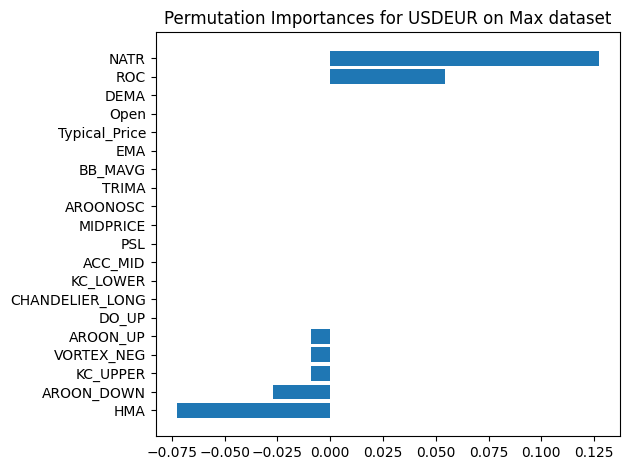

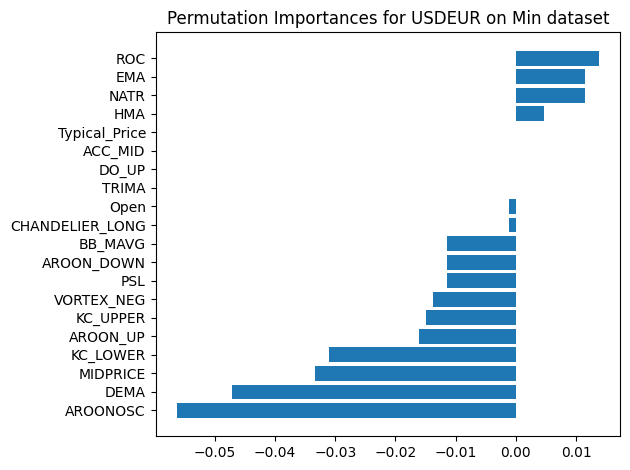

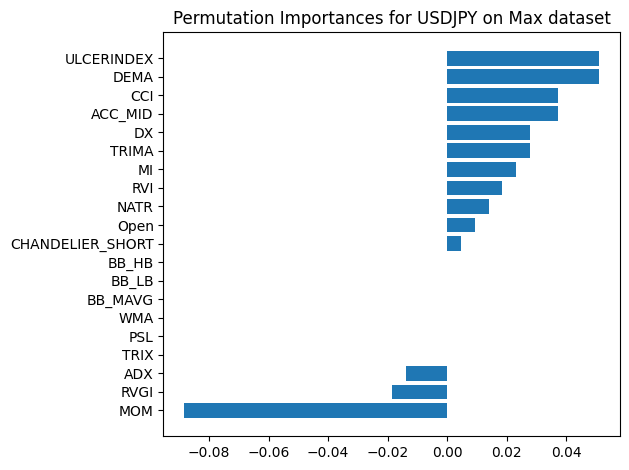

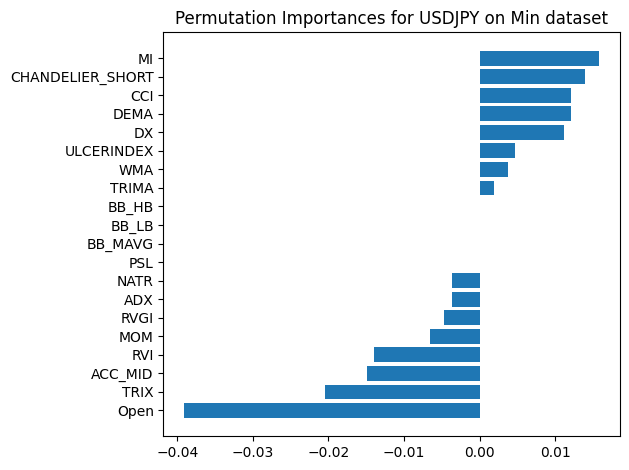

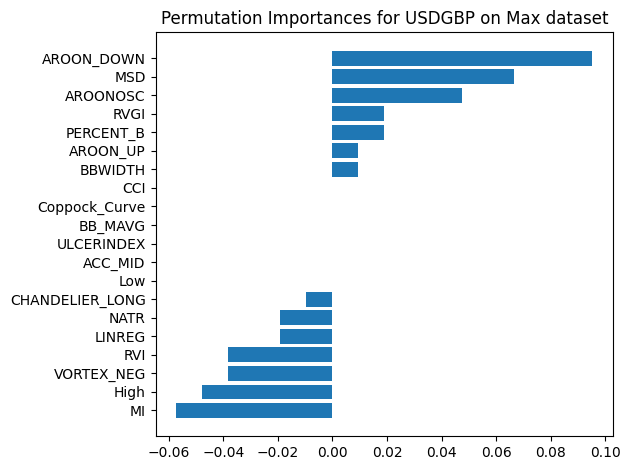

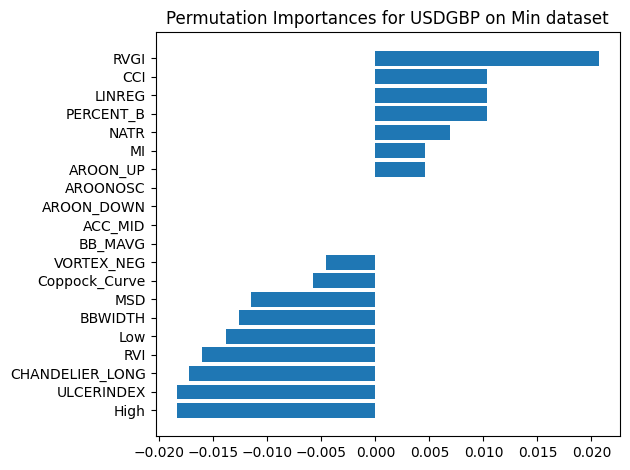

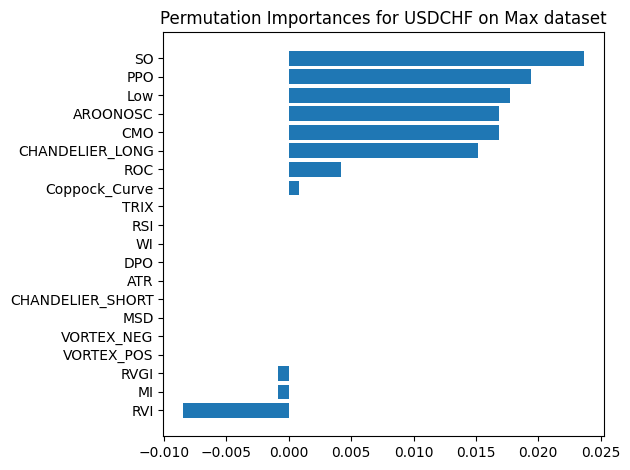

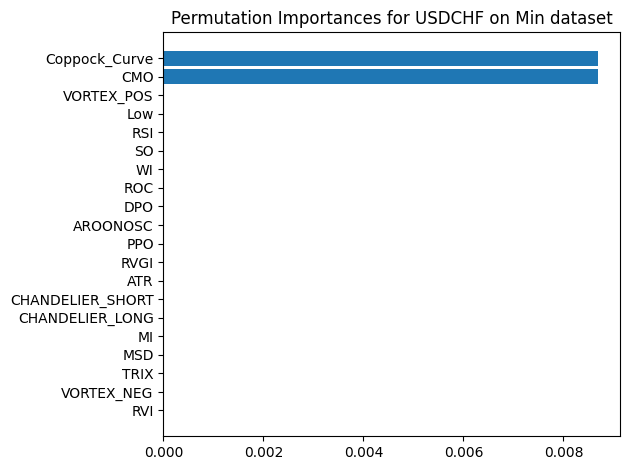

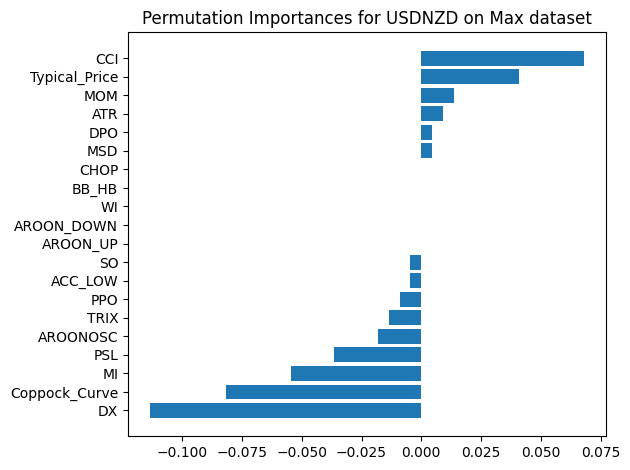

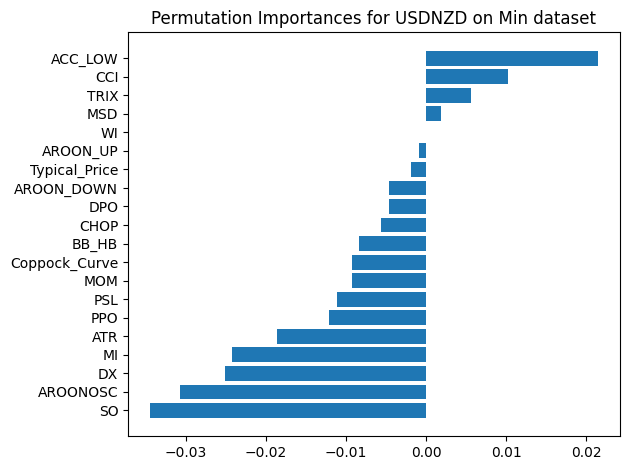

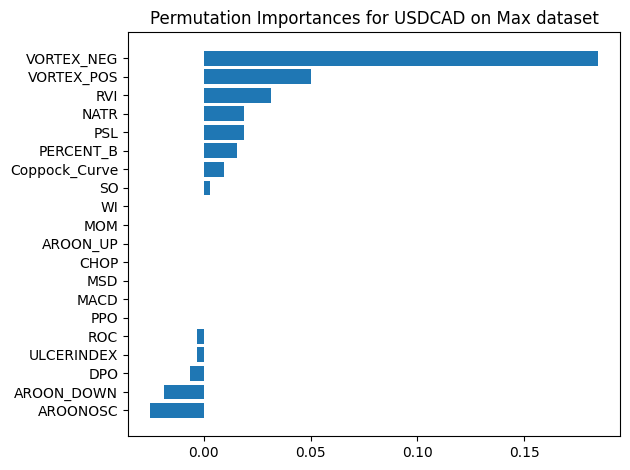

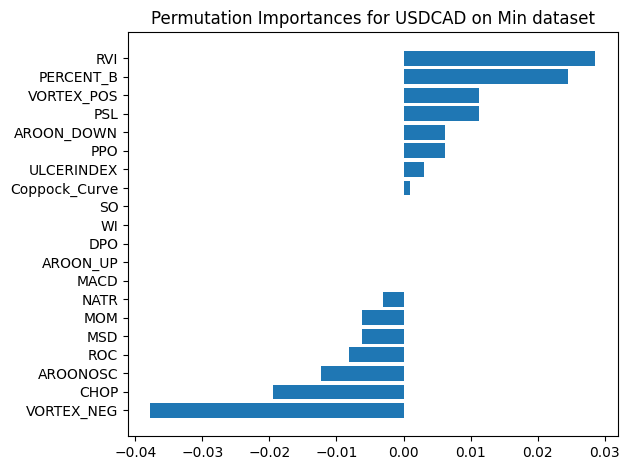

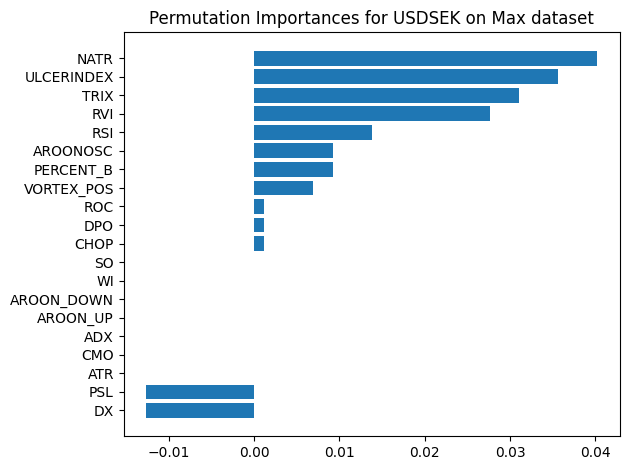

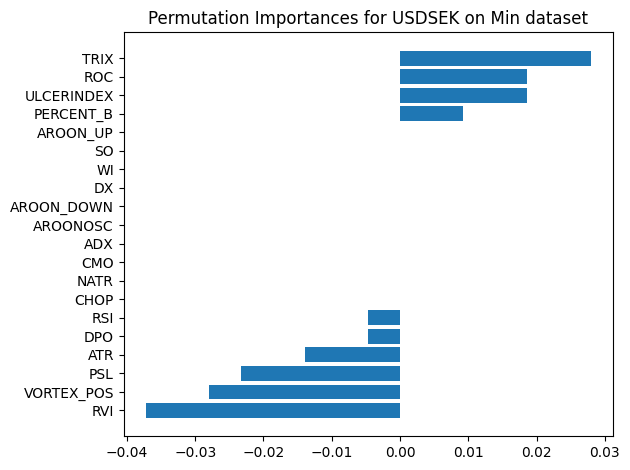

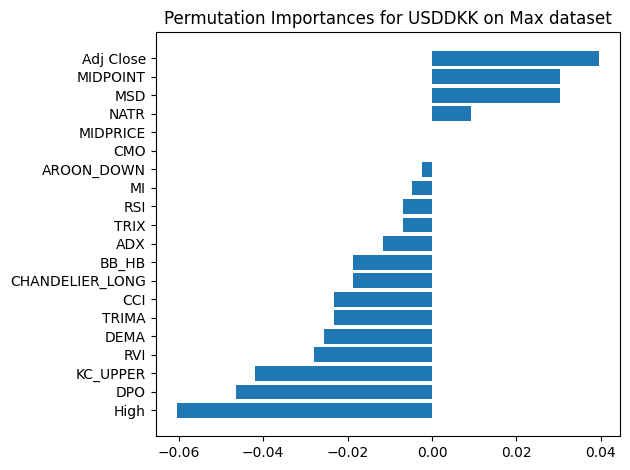

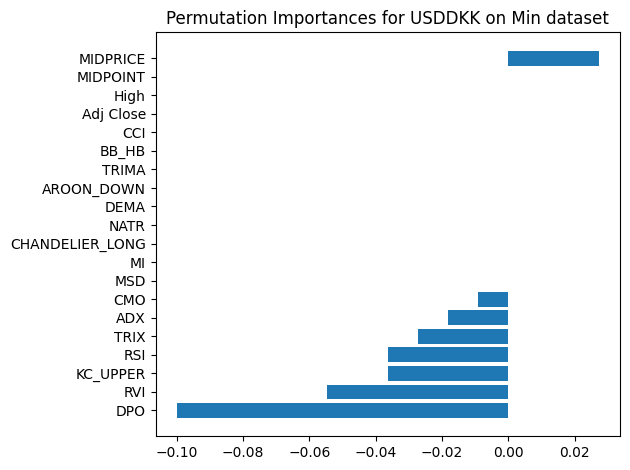

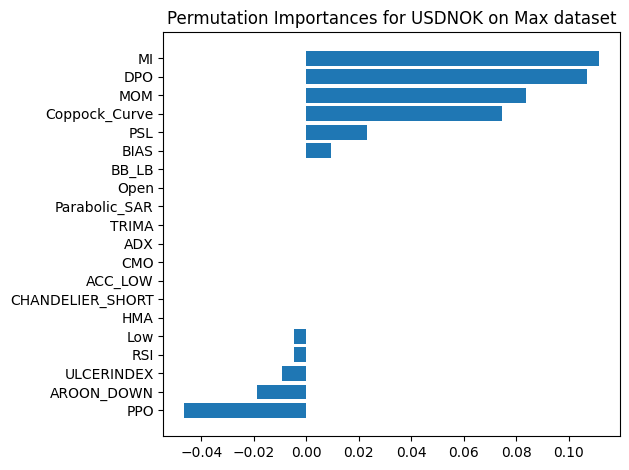

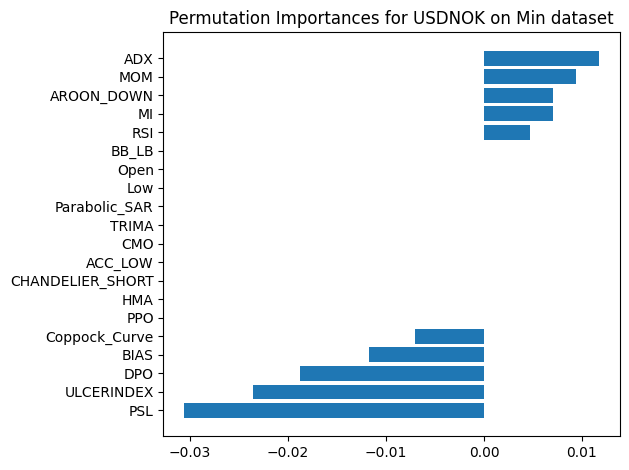

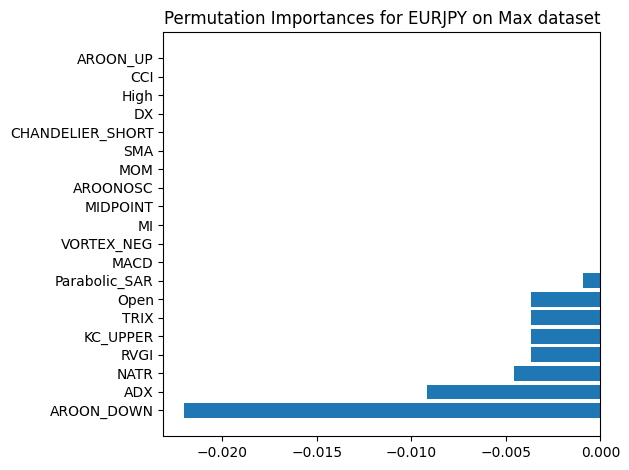

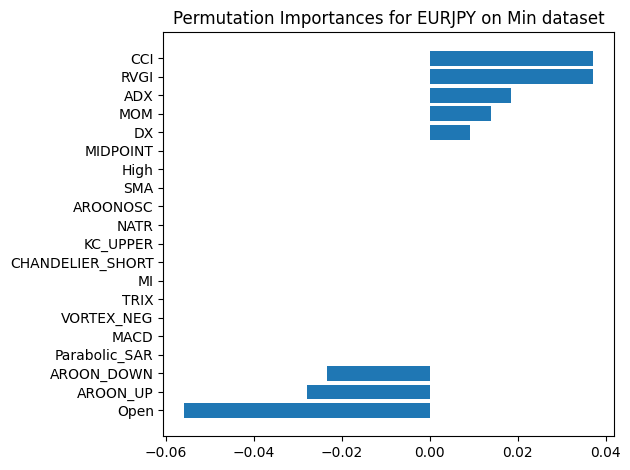

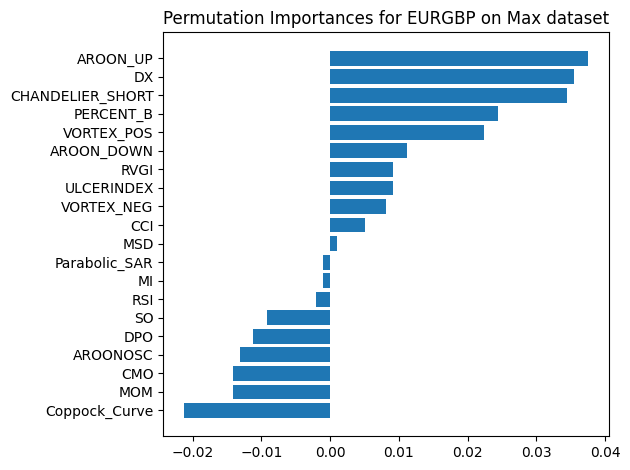

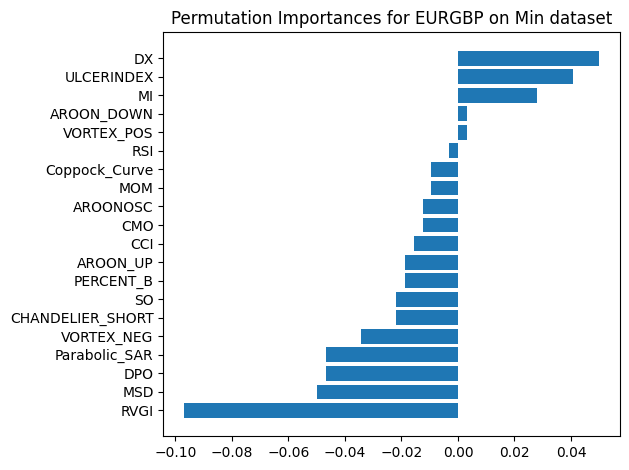

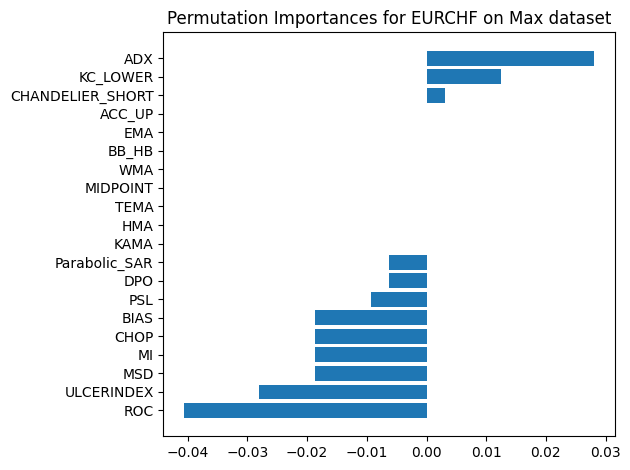

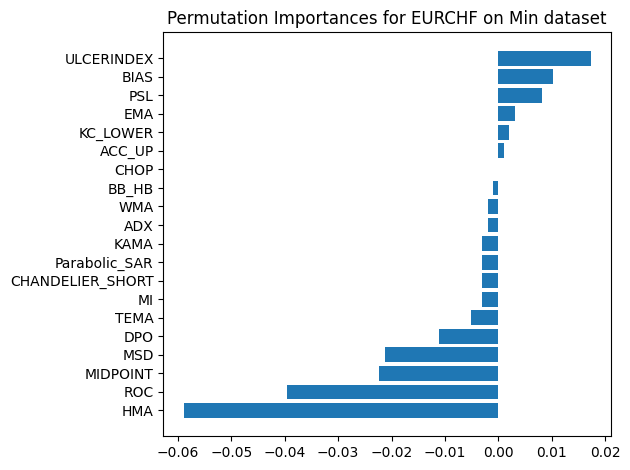

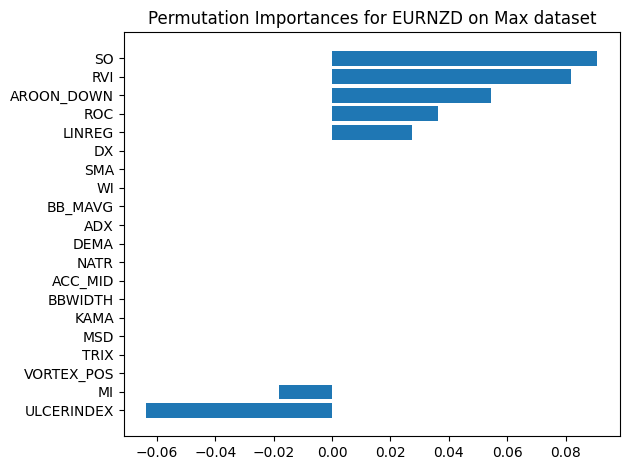

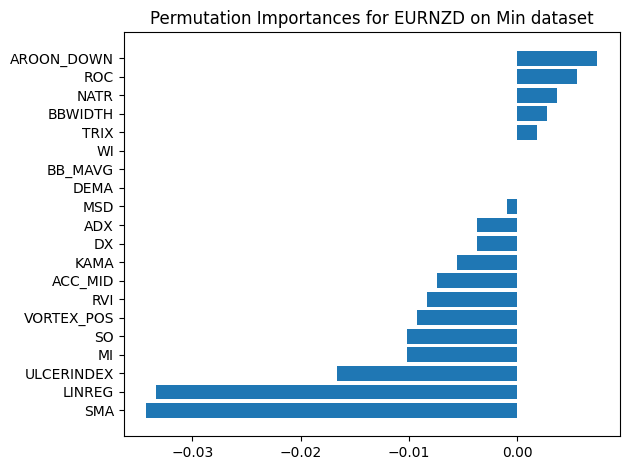

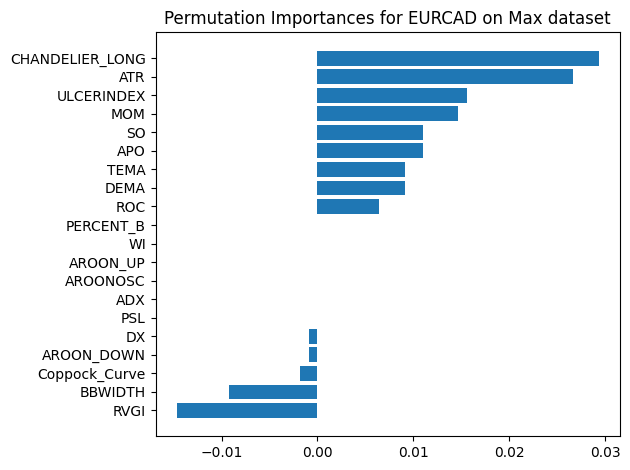

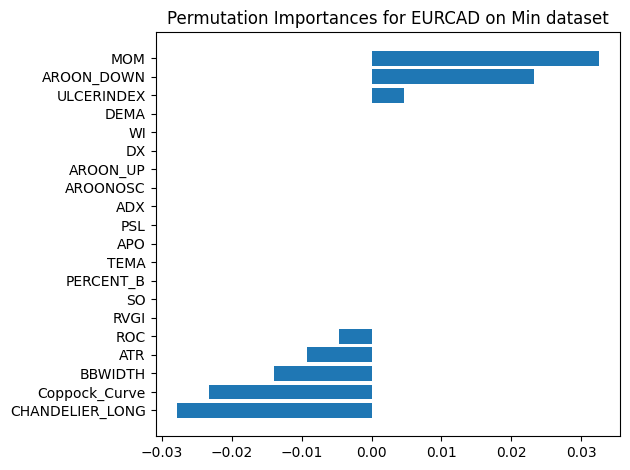

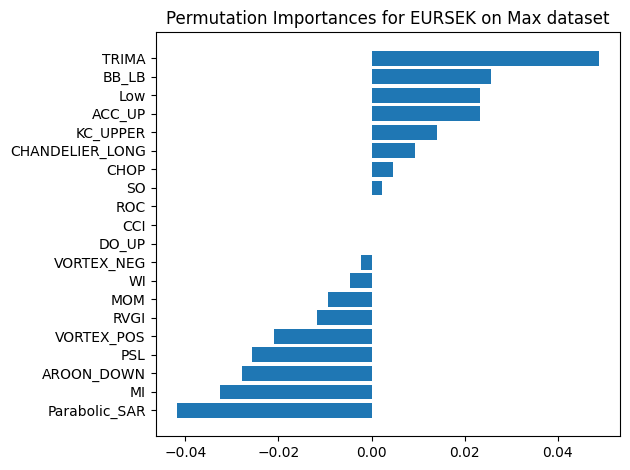

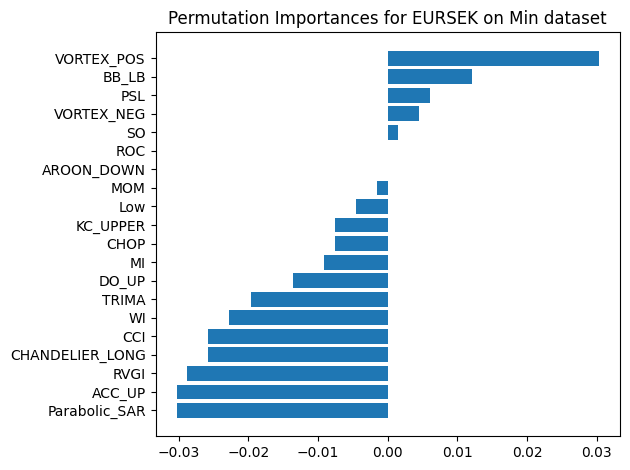

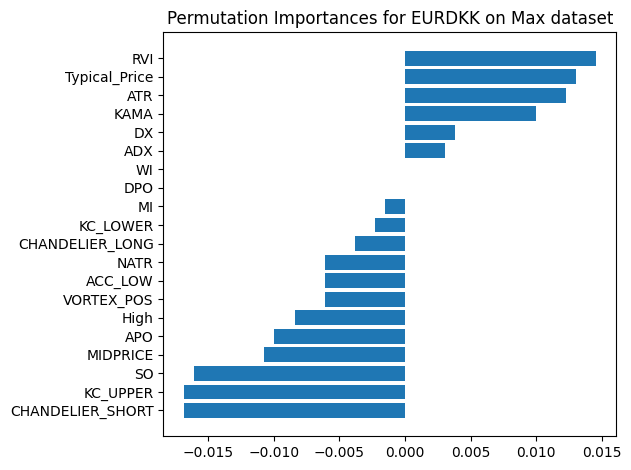

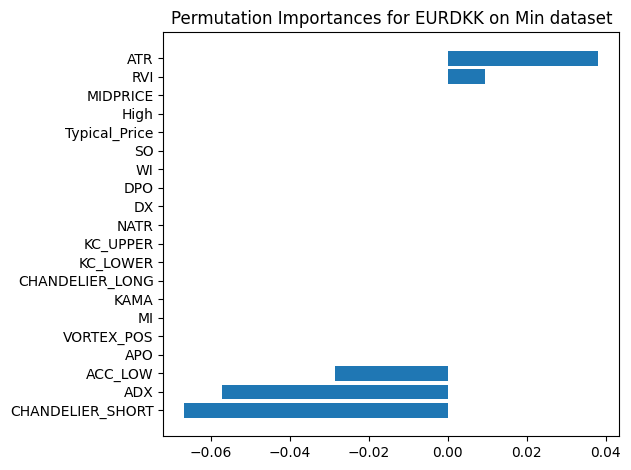

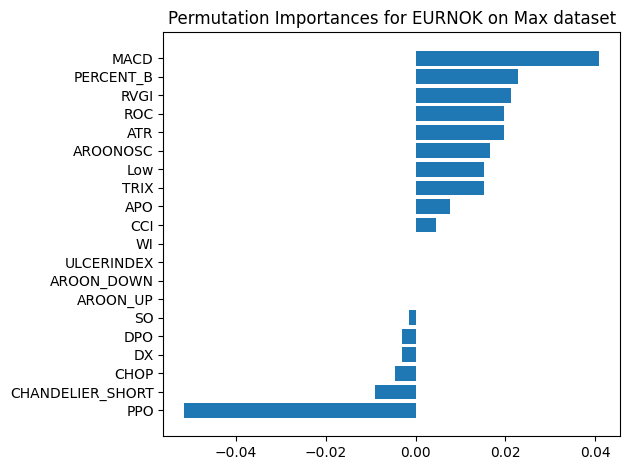

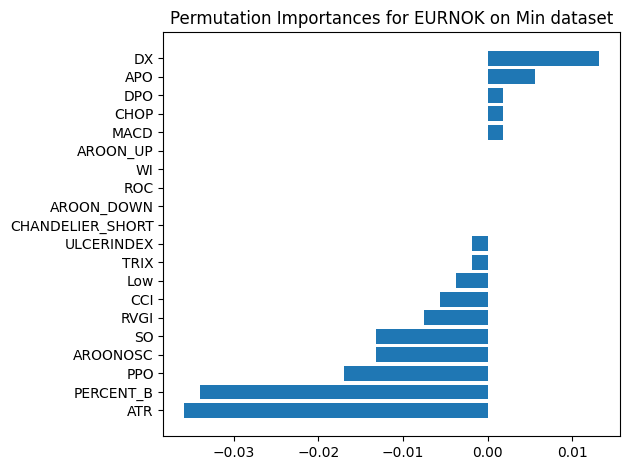

In [55]:
# Plot the PFI scores
plot_pfi(PFI_Final)

In [56]:
# Output path for saving the results in Excel format
output_path = path + '/Strategy_PFI_Cum_Month.xlsx'

# Prepare the writer to save data in Excel format
writer = pd.ExcelWriter(output_path, engine='xlsxwriter')

# Convert and save the data in Excel sheets
for currency, datasets in PFI_Final.items():
    for dataset, pfi_values in datasets.items():
        # Consider only features with positive PFI values
        positive_pfi_values = [val for val in pfi_values if val[1] > 0]

        # If no feature has positive PFI value, store a placeholder message
        if not positive_pfi_values:
            df = pd.DataFrame([0], columns=["None features are important"], index=[dataset])
        else:
            # Convert the results into a DataFrame for saving
            df = pd.DataFrame(positive_pfi_values, columns=["Feature", "PFI"]).set_index("Feature").T

        # Save the data in a new sheet
        df.to_excel(writer, sheet_name=f"{currency}_{dataset}")

# Save the Excel file
writer.save()
